# **DSG Master Code**

## **1. PACKAGES**

In [0]:
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import numpy as np
import os
import gzip
import scipy.stats
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests
import json
from pandas.io.json import json_normalize

## **2. DATA PREPROCESSING**

### 2.1. IMPORT and MEGRER

In [0]:
# json cols
cols = ['products', 'dproducts', 'carproducts', 'ocarproducts', 'ofacets', 'odproducts', 'oproducts']

In [0]:
# import data
df_session = pd.read_csv('data/train_session.csv.gz',      compression='gzip')
df_train   = pd.read_csv('data/train_tracking.csv.gz',     compression='gzip')
df_test    = pd.read_csv('data/test_tracking.csv.gz',      compression='gzip')
df_product = pd.read_csv('data/productid_category.csv.gz', compression='gzip')

In [0]:
# import other data
cp   = pd.read_csv('data/cproduct.csv')
rvo  = pd.read_csv("data/ocarproducts_per_sku.csv")
skup = pd.read_csv('data/price_per_sku.csv')
po   = pd.read_csv('data/product_oproduct.csv')
del po["sid"]

In [151]:
# dimensions
print(df_session.shape)
print(df_product.shape)
print(df_train.shape)
print(df_test.shape)

(133123, 2)
(10635919, 4)
(1355095, 31)
(908233, 31)


In [0]:
# test set indicator
df_train["test"] = 0
df_test["test"]  = 1

In [153]:
# merge data
df = df_train.append(df_test)
df = df.merge(df_session, how = "left", on = "sid")
df.shape

(2263328, 33)

In [154]:
# merge additional data
print(df.shape)
df = pd.concat([df, po], axis = 1)
print(df.shape)
df = pd.concat([df, cp], axis = 1)
print(df.shape)
df = df.merge(skup, how = "left", on = "sku")
print(df.shape)
df = df.merge(rvo[["sku", "ocar_price", "ocar_rvoter", "ocar_stock", "ocar_rate"]], how = "left", on = "sku")
print(df.shape)

(2263328, 33)
(2263328, 43)
(2263328, 53)
(2263328, 54)
(2263328, 58)


In [158]:
#
#prod = pd.read_csv('data/productid_category.csv.gz',     compression='gzip')
prod = prod[["product_id", "category_product_id_level1"]]
prod.columns = ["sku", "category"]
prod.head()

,sku,category
0,i1t4Uq+NqhB0O4d2J/jzCA==,1387712
1,a0OxyFVArDl0UzhpmP1L5w==,13
2,mQ+KVVCUfLKmb2Rlo/FT3A==,22
3,KVg9N8j/cuLPkvIcSzYemw==,5
4,N9mErkxf69NX7uuqysEWGA==,2626413


### 2.2. AGGREGATIONS

In [0]:
##### FUNCTION FOR AGGREGATING DATA
def aggregate_data(data, id_var, label = None):
    
    
    ### SEPARATE FEATURES
  
    # display info
    print("- Preparing the dataset...")

    # find factors
    data_factors = [f for f in data.columns if data[f].dtype == "object"]
    
    # partition subsets
    num_data = data[[id_var] + list(set(data.columns) - set(data_factors))]
    fac_data = data[data_factors]
    
    # display info
    num_facs = fac_data.shape[1] - 1
    num_nums = num_data.shape[1] - 1
    print("- Extracted %.0f factors and %.0f numerics..." % (num_facs, num_nums))


    ##### AGGREGATION
 
    # aggregate numerics
    if (num_nums > 0):
        print("- Aggregating numeric features...")
        num_data = num_data.groupby([id_var]).agg(["mean", "std", "min", "max", "sum"])
        num_data.columns = ["_".join(col).strip() for col in num_data.columns.values]
        num_data = num_data.sort_index()

    # aggregate factors
    if (num_facs > 0):
        print("- Aggregating factor features...")
        fac_data = fac_data.groupby([id_var]).agg([("mode",   lambda x: scipy.stats.mode(x)[0][0]),
                                                 ("nunique",  lambda x: x.nunique())])
        fac_data.columns = ["_".join(col).strip() for col in fac_data.columns.values]
        fac_data = fac_data.sort_index()


    ##### MERGER

    # merge numerics and factors
    if ((num_facs > 0) & (num_nums > 0)):
        agg_data = pd.concat([num_data, fac_data], axis = 1)
    
    # use factors only
    if ((num_facs > 0) & (num_nums == 0)):
        agg_data = fac_data
        
    # use numerics only
    if ((num_facs == 0) & (num_nums > 0)):
        agg_data = num_data
        

    ##### LAST STEPS

    # update labels
    if label != None:
        agg_data.columns = [label + "_" + str(col) for col in agg_data.columns]
    
    # impute zeros for SD
    #stdevs = agg_data.filter(like = "_std").columns
    #for var in stdevs:
    #    agg_data[var].fillna(0, inplace = True)

    # display info
    print("- Final dimensions:", agg_data.shape)
    
    # return dataset
    return agg_data

In [0]:
### feature: mean target per event type

# extract data for counting
sid_ids  = df_train.sid.unique()[0:1331]
df_count = df[df.sid.isin(list(sid_ids))]
df       = df[-df.sid.isin(list(sid_ids))]

# compute mean targets
df_count.target[df_count.target == False] = 0
df_count.target[df_count.target == True]  = 1
df_count.target = df_count.target.astype("int32")
y_per_type_simplified = df_count.groupby("type", as_index = False).target.mean()
y_per_type_simplified.columns = ["type", "y_per_type"]

# feature: mean target per event type
df = df.merge(y_per_type_simplified, how = "left", on = ["type"])

In [0]:
# duration variables
df['duration_no_days'] = df.duration.apply(lambda x: x[6:])
df['hours'] = df.duration_no_days.apply(lambda x: x[0:3]).astype('int')
df['min'] = df.duration_no_days.apply(lambda x: x[4:6]).astype('int')
df['secs'] = df.duration_no_days.apply(lambda x: x[7:9]).astype('int')
df['sec'] = df['hours']*360 + df['min']*60 + df['secs']
df.drop(['duration', 'duration_no_days','hours','min','secs'], axis=1, inplace=True)

In [0]:
# keep only last/first 20 pages
#print(df.shape)
#kk = 20
#df = df.sort_values(["sid", "sec"])
#df = df.groupby("sid").tail(kk)
#print(df.shape)

In [0]:
# feature: number of page views
pages = df["sid"].value_counts().reset_index()
pages.columns = ["sid", "pages"]

In [0]:
# feature: no. unique queries
df["unique_queries"]  = df.groupby("sid")["query"].agg(lambda x:  x.nunique())
df["unique_oqueries"] = df.groupby("sid")["oquery"].agg(lambda x: x.nunique())

# feature: no. unique skus
df["unique_skus"] = df.groupby("sid")["sku"].agg(lambda x: x.nunique())

# feature: no. unique offerid
df["unique_offerid"] = df.groupby("offerid")["offerid"].agg(lambda x: x.nunique())

# feature: no. unique idcar
df["unique_idcar"]  = df.groupby("idcar")["idcar"].agg(lambda x: x.nunique())
df["unique_oidcar"] = df.groupby("oidcar")["oidcar"].agg(lambda x: x.nunique())

In [0]:
### feature: are there any filters?
import re

facets = []
def facets_bla(x):
  if str(x)!='nan':
    facets.append(np.sum([int(i[2:]) for i in re.findall(r': \w+', x)]))
  else:
    facets.append(0)

df.facets.apply(lambda x: facets_bla(x))
df["num_facets"] = facets

facets = []
df.ofacets.apply(lambda x: facets_bla(x))
df["num_ofacets"] = facets

In [0]:
# feature: resolution
df["resolution"] = df["rh"] * df["rw"]

In [0]:
# feature: last type simplified (1/2)
dfg = df.sort_values(["sid", "sec"])
dfg = dfg.groupby("sid").type_simplified.last().reset_index()

In [0]:
# feature: sec per type simplified (1/2)
dfs = df.sort_values(["sid", "sec"])
dfs["sec_on_page"] = dfs.groupby("sid")["sec"].diff()
sums = dfs.groupby(["sid", "type_simplified"], as_index = False)["sec_on_page"].sum()
sums.columns = ["sid", "type_simplified", "sec_per_type_simplified"]

# feature: sec per type simplified (2/2)
df = df.merge(sums, how = "left", on = ["sid", "type_simplified"])

In [0]:
# feature: sec per type (1/2)
dfss = df.sort_values(["sid", "sec"])
dfss["sec_on_page"] = dfss.groupby("sid")["sec"].diff()
sumss = dfss.groupby(["sid", "type"], as_index = False)["sec_on_page"].sum()
sumss.columns = ["sid", "type", "sec_per_type"]

# feature: sec per type (2/2)
df = df.merge(sumss, how = "left", on = ["sid", "type"])

In [0]:
# feature: sec on page aggregates (1/2)
dfsec = df.sort_values(["sid", "sec"])
dfsec["sec_on_page"] = dfsec.groupby("sid")["sec"].diff()
dfsec = dfsec.groupby("sid").sec_on_page.agg(["mean", "min", "max", "std"]).reset_index()
dfsec.columns = ["sid", "sec_on_page_mean", "sec_on_page_min", "sec_on_page_max", "sec_on_page_sd"]

In [0]:
# feature: sec on page - last 5 - aggregates (1/2)
dfsecl = df.sort_values(["sid", "sec"])
dfsecl = dfsecl.groupby("sid").tail(5)
dfsecl["sec_on_page"] = dfsecl.groupby("sid")["sec"].diff()
dfsecl = dfsecl.groupby("sid").sec_on_page.agg(["mean", "min", "max", "std"]).reset_index()
dfsecl.columns = ["sid", "l5_sec_on_page_mean", "l5_sec_on_page_min", "l5_sec_on_page_max", "l5_sec_on_page_sd"]

# feature: sec on page - last 3 - aggregates (1/2)
dfsecj = df.sort_values(["sid", "sec"])
dfsecj = dfsecj.groupby("sid").tail(3)
dfsecj["sec_on_page"] = dfsecj.groupby("sid")["sec"].diff()
dfsecj = dfsecj.groupby("sid").sec_on_page.agg(["mean", "min", "max", "std"]).reset_index()
dfsecj.columns = ["sid", "l3_sec_on_page_mean", "l3_sec_on_page_min", "l3_sec_on_page_max", "l3_sec_on_page_sd"]

In [0]:
# dummy encoding for some factors
df = pd.concat([df[["type", "type_simplified"]], 
                pd.get_dummies(df, drop_first = False, columns = ["type", "device", "stype", "type_simplified", "siteid"])],
                axis = 1)

In [0]:
# drop jsons
omits = ['products', 'dproducts', 'carproducts', 'ocarproducts', 'ofacets', 'odproducts', 'oproducts']
for var in omits:
    del df[var]

In [178]:
print(df.shape)
df = df.merge(prod, how = "left", on = "sku")
print(df.shape)

(2248768, 97)
(2251956, 98)


In [0]:
# drop some factors
omits = ["query", "facets", "idcar", "sku", "offerid", "oidcar", "oquery"]
for var in omits:
    del df[var]

In [180]:
# aggregating
df_agg = aggregate_data(df, id_var = "sid")

- Preparing the dataset...
- Extracted 4 factors and 86 numerics...
- Aggregating numeric features...
- Aggregating factor features...
- Final dimensions: (220542, 436)


In [0]:
# clean up
omits = ["test", "unique_queries", "unique_oqueries", "unique_skus", "unique_offerid", "unique_idcar", "unique_idocar"]
for var in omits:
    try:
      del df_agg[str(var) + "_std"]
    except:
      pass
    try:
      del df_agg[str(var) + "_min"]
    except:
      pass
    try:
      del df_agg[str(var) + "_max"]
    except:
      pass
    try:
      del df_agg[str(var) + "_sum"]
    except:
      pass

In [0]:
# clean up seconds
del df_agg["sec_min"]
del df_agg["sec_per_type_simplified_min"]
del df_agg["sec_per_type_simplified_max"]
del df_agg["sec_per_type_simplified_sum"]
del df_agg["sec_per_type_min"]
del df_agg["sec_per_type_max"]
del df_agg["sec_per_type_sum"]

In [0]:
# clean up target
df_agg["target"] = df_agg.target_mode
del df_agg["target_mode"]
del df_agg["target_nunique"]

In [184]:
# feature: number of pages (2/2)
print(df_agg.shape)
df_agg["sid"] = df_agg.index
df_agg = df_agg.merge(pages, how = "left", on = "sid")
df_agg = df_agg.set_index("sid")
print(df_agg.shape)

(220542, 404)
(220542, 405)


In [185]:
# feature: last type simplified (2/2)
print(df_agg.shape)
df_agg["sid"] = df_agg.index
df_agg = df_agg.merge(dfg, how = "left", on = "sid")
df_agg = df_agg.set_index("sid")
print(df_agg.shape)

(220542, 405)
(220542, 406)


In [0]:
# feature: seconds per page
#df_agg["sec_per_page"] = df_agg.pages / df_agg.sec_max 
#df_agg["sec_per_page"].isinf()

In [187]:
# feature: sec on page aggregates (2/2)
print(df_agg.shape)
df_agg["sid"] = df_agg.index
df_agg = df_agg.merge(dfsec, how = "left", on = ["sid"])
df_agg = df_agg.set_index("sid")
print(df_agg.shape)

(220542, 406)
(220542, 410)


In [188]:
# feature: sec on page - last 5 - aggregates (2/2)
print(df_agg.shape)
df_agg["sid"] = df_agg.index
df_agg = df_agg.merge(dfsecl, how = "left", on = ["sid"])
df_agg = df_agg.set_index("sid")
print(df_agg.shape)

# feature: sec on page - last 3 - aggregates (2/2)
print(df_agg.shape)
df_agg["sid"] = df_agg.index
df_agg = df_agg.merge(dfsecj, how = "left", on = ["sid"])
df_agg = df_agg.set_index("sid")
print(df_agg.shape)

(220542, 410)
(220542, 414)
(220542, 414)
(220542, 418)


In [189]:
# label encoder for remaining factors
data_factors = [f for f in df_agg.columns if df_agg[f].dtype == "object"]
for var in data_factors:
    df_agg[var], _ = pd.factorize(df_agg[var])
df_agg.shape

(220542, 418)

In [0]:
# save data
df_agg.to_csv("data/data_agg_last.csv.gz", index = True, compression = "gzip")

In [191]:
l = pd.read_csv("data/dfa4_sid.csv")
df_agg = df_agg.merge(l, how = "left", on = "sid")
df_agg.shape

(220542, 560)

In [0]:
# load data
#df_agg = pd.read_csv("data/data_agg_last.csv.gz", compression = "gzip")

In [0]:
# merge graph-based features
#g1 = pd.read_csv("data/gg1.csv")
#g2 = pd.read_csv("data/gg2.csv")
#g3 = pd.read_csv("data/graphs3.csv")
#graphs = pd.concat([g1, g2, g3], axis = 0)
#print(graphs.shape)
#graphs = graphs.drop_duplicates(axis = 1)
#print(graphs.shape)

#df_agg = df_agg.merge(g1, how = "right", on = "sid")
#df_agg.shape

In [0]:
#gg = pd.concat([g1, g2], axis = 0)
#gg = gg.drop_duplicates()
#gg.shape

In [195]:
print(df_agg.shape)

(220542, 560)


## **3. MODELING**

## 3.1. LIGHT GBM

In [0]:
# warnings
import warnings
warnings.filterwarnings("ignore")

In [197]:
# data partitioning
train = df_agg[df_agg.test_mean == 0]
test  = df_agg[df_agg.test_mean == 1]
print(train.shape)
print(test.shape)

(131792, 560)
(88750, 560)


In [0]:
# remove target
y = train.target
y[y == False] = 0
y[y == True]  = 1
y = y.astype("int32")

In [0]:
# remove variables
omits = ["test_mean", "target"]
for var in omits:
    del train[str(var)]
    del test[str(var)]

In [0]:
# excluded features
excluded_feats = [col for col in train.columns if  ((col.startswith("type_simplified_") & (col.endswith("_min") | col.endswith("_max")))
                                           |  (col.startswith("type_") & (col.endswith("_min") | col.endswith("_max"))) |
                                            (col.startswith("type_") & (col.endswith("_min") | col.endswith("_max")))|
                                     col.startswith("siteid_") |  col.startswith("device_") |  col.startswith("stype_"))]
features = [f for f in train.columns if f not in excluded_feats]
features = [f for f in features if f not in "sid"]

In [0]:
### PARAMETERS

# seed
seed = 42

# parallel settings
cores = 20

# learner settings
metric   = "logloss"
verbose  = 100
stopping = 200

# CV settings
num_folds = 4
shuffle   = True

# lightGBM
'''gbm = lgb.LGBMClassifier(n_estimators  = 5000,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = seed,
                         num_threads      = cores)
'''

gbm = xgb.XGBClassifier(max_depth = 7, n_estimators = 5000, learning_rate = 0.007,
                        max_bin = 16, tree_method ='gpu_hist', 
                        reg_alpha = 0.5, reg_lambda = 0.5,
                        verbose = verbose, random_state = seed)

In [0]:
# data partitinoing
folds = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = shuffle)

# placeholders
valid_aucs_cv = np.zeros(num_folds) 
test_preds_cv = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()
preds_val_cv = np.zeros(len(train))

In [203]:
### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):
    
    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    
    # train lightGBM
    gbm = gbm.fit(trn_x, trn_y, 
                  eval_set = [(trn_x, trn_y), (val_x, val_y)], 
                  eval_metric = metric, 
                  verbose = verbose, 
                  early_stopping_rounds = stopping)
    
    # save number of iterations
    num_iter_cv = gbm.best_iteration
    
    # predictions
    valid_preds_cv = gbm.predict_proba(val_x, ntree_limit = num_iter_cv)[:, 1]
    valid_aucs_cv[n_fold] = log_loss(val_y, valid_preds_cv)
    test_preds_cv += gbm.predict_proba(test[features], ntree_limit = num_iter_cv)[:, 1] / folds.n_splits 
    preds_val_cv[val_idx] = valid_preds_cv
    
    
    # importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["Importance"] = gbm.feature_importances_
    fold_importance_df["Fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
    
    # print performance
    print("----------------------")
    print("Fold%2d LOGLOSS: %.6f" % (n_fold + 1, valid_aucs_cv[n_fold]))
    print("----------------------")
    print("")
    
    # clear memory
    #del trn_x, trn_y, val_x, val_y
    
# print overall performance    
auc = np.mean(valid_aucs_cv)
print("Cross-Validation LOGLOSS score %.6f" % np.mean(valid_aucs_cv))

[0]	validation_0-logloss:0.688251	validation_1-logloss:0.688278
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 200 rounds.
[100]	validation_0-logloss:0.408152	validation_1-logloss:0.411914
[200]	validation_0-logloss:0.310453	validation_1-logloss:0.318064
[300]	validation_0-logloss:0.271669	validation_1-logloss:0.283588
[400]	validation_0-logloss:0.254757	validation_1-logloss:0.271024
[500]	validation_0-logloss:0.245798	validation_1-logloss:0.266293
[600]	validation_0-logloss:0.239885	validation_1-logloss:0.264545
[700]	validation_0-logloss:0.235182	validation_1-logloss:0.264042
[800]	validation_0-logloss:0.231107	validation_1-logloss:0.26379
[900]	validation_0-logloss:0.227886	validation_1-logloss:0.263691
[1000]	validation_0-logloss:0.225254	validation_1-logloss:0.263678
[1100]	validation_0-logloss:0.222893	validation_1-logloss:0.263658
[1200]	validation_0-logloss:0.220668	valida

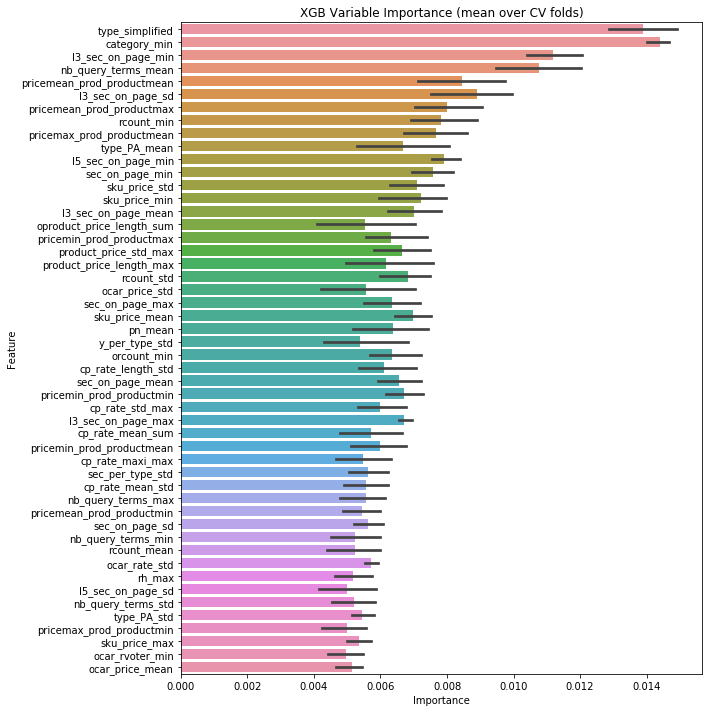

In [208]:
##### VARIABLE IMPORTANCE

# load importance    
top_feats = 50
cols = feature_importance_df[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by = "Importance", ascending = False)[0:top_feats].index
importance = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
# plot variable importance
plt.figure(figsize = (10, 10))
sns.barplot(x = "Importance", y = "Feature", data = importance.sort_values(by = "Importance", ascending = False))
plt.title('XGB Variable Importance (mean over CV folds)')
plt.tight_layout()

## **4. CREATE SUBMISSION**

In [0]:
# create submission
test = test.reset_index()
test["target"] = test_preds_cv
subm = test[["sid", "target"]]
subm.to_csv("submissions/top300_xgb_" + str(auc)[2:9]+ ".csv", index=False)
pd.DataFrame(preds_val_cv).to_csv("pred_valid/top300_xgb_" + str(auc)[2:9]+ ".csv", index=False)

In [0]:
import io, math, requests

def submit_prediction(df, sep=',', comment='', **kwargs):
    TOKEN='b488bb2563e59cdecf8bbf5cce438cdbead96fc37c443afa5b50746c1f89d35b5eb4eda85c0573e483ba618d90631f3797c34e3fefa65b7d5f9c9c3cfe30cc9b'
    URL='https://qscore.datasciencegame.com/api/submissions'
    buffer = io.StringIO()
    df.to_csv(buffer, sep=sep, **kwargs)
    buffer.seek(0)
    r = requests.post(URL, headers={'Authorization': 'Bearer {}'.format(TOKEN)},files={'datafile': buffer},data={'comment':comment})
    if r.status_code == 429:
        raise Exception('Submissions are too close. Next submission is only allowed in {} seconds.'.format(int(math.ceil(int(r.headers['x-rate-limit-remaining']) / 1000.0))))
    if r.status_code != 200:
        raise Exception(r.text)

In [213]:
# submit prediction
submit_prediction(subm, sep=',', index=True, comment='xgb 4f plus product cat ')


# lgb 3000-100, k=3, f=48:                                  0.271650 CV | 0.27086 PB
# lgb 3000-100, k=3, f=163 (add sec and DE):                0.269679 CV | 0.26966 PB
# lgb 3000-100, k=3, f=164 (add pages number):              0.269432 CV | 0.26965 PB
# lgb 3000-100, k=3, f=164 (add product json):              0.269139 CV | 0.26949 PB
# lgb 3000-100, k=3, f=214 (add opr, siteid, query, sums):  0.268922 CV | 0.26945 PB

# xgb 3000-100, k=3, f=279:               0.269320 CV | 0.26964 PB
# xgb 3000-100, k=3, f=229: (DONT USE)    0.268983 CV | 0.26921 PB
# xgb 3000-100, k=3, f=299: (RVOTERS)     0.268274 CV | 0.26797 PB
# xgb 3000-100, k=3, f=302: (SKU_PRICE)   0.267766 CV | 0.26743 PB
# xgb 3000-100, k=3, f=313:               0.267395 CV | 0.26719 PB


# xgb 3000-100, k=3, f=322 (correct time) 0.265493 CV | 0.26462 PB
# xgb 3000-100, k=3, f=326 (correct time) 0.265467 CV | 0.26456 PB

Exception: ignored

In [0]:
suball = pd.read_csv("submissions/xgb_2646998.csv")
subl20 = pd.read_csv("submissions/l20_xgb_2665273.csv")
subf20 = pd.read_csv("submissions/f20_xgb_2680510.csv")

In [0]:
target = suball.target*0.6 + subl20.target*0.2 + subf20.target*0.2
comb = pd.DataFrame({"sid": suball.sid, "target": target})

In [0]:
# function to subimt directly from the notebook
def submit_prediction(df, sep=',', comment='', **kwargs):
    TOKEN='b488bb2563e59cdecf8bbf5cce438cdbead96fc37c443afa5b50746c1f89d35b5eb4eda85c0573e483ba618d90631f3797c34e3fefa65b7d5f9c9c3cfe30cc9b'
    URL='https://qscore.datasciencegame.com/api/submissions'
    buffer = io.StringIO()
    df.to_csv(buffer, sep=sep, **kwargs)
    buffer.seek(0)
    r = requests.post(URL, headers={'Authorization': 'Bearer {}'.format(TOKEN)},files={'datafile': buffer},data={'comment':comment})
    if r.status_code == 429:
        raise Exception('Submissions are too close. Next submission is only allowed in {} seconds.'.format(int(math.ceil(int(r.headers['x-rate-limit-remaining']) / 1000.0))))
    if r.status_code != 200:
        raise Exception(r.text)

In [0]:
# submit prediction
submit_prediction(subm, sep=',', index=True, comment='0.8*xgb 5 folds + 0.2 XGB with first 20 an last 20')